# MLP
## read data

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import pandas as pd
import json

from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [ ]:
data1 = []
data2 = []
data3 = []
test = []

# Assuming the NDJSON data is stored in a file called 'data.ndjson'
with open("domain1_train.json", 'r') as file:
    for line in file:
        dict = json.loads(line.strip())
        dict["domain"] = 1
        data3.append(dict)
# Assuming the NDJSON data is stored in a file called 'data.ndjson'
with open("domain2_train.json", 'r') as file:
    for line in file:
        dict = json.loads(line.strip())
        dict["domain"] = 2
        data3.append(dict)

with open("test_set.json", 'r') as file:
    for line in file:
        dict = json.loads(line.strip())
        test.append(dict)


# Assuming the NDJSON data is stored in a file called 'data.ndjson'
with open("domain1_train.json", 'r') as file:
    for line in file:
        dict = json.loads(line.strip())
        dict["domain"] = 1
        data1.append(dict)
# Assuming the NDJSON data is stored in a file called 'data.ndjson'
with open("domain2_train.json", 'r') as file:
    for line in file:
        dict = json.loads(line.strip())
        dict["domain"] = 2
        data2.append(dict)

df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)
df3 = pd.DataFrame(data3)
test = pd.DataFrame(test)




# Convert sequences to BoW representation
def sequences_to_bow(sequences, vocab_size):
    matrix = np.zeros((len(sequences), vocab_size))
    for i, sequence in enumerate(sequences):
        for token in sequence:
            if token < vocab_size:
                matrix[i][token] += 1
    return matrix

vocab_size = 5000  # as mentioned
df3['text_strings'] = df3['text'].apply(lambda x: ' '.join(map(str, x)))

df3['text_dup'] = df3['text'].apply(tuple) # drop duplicates
df3.drop_duplicates(subset='text_dup', keep='first', inplace=True)
df3.drop(columns='text_dup', inplace=True)
y = df3['label']

X = sequences_to_bow(df3['text'], vocab_size)
X_pred = sequences_to_bow(test['text'], vocab_size)
Xtrain,Ytrain = np.array(X),np.array(y)
X_train,X_test,Y_train,Y_test = train_test_split(Xtrain,Ytrain,test_size=0.25,stratify=Ytrain)


In [ ]:
df3.groupby('model').count()

,text,label,domain,text_strings
model,,,,
0.0,2344,2344,2344,2344
1.0,2349,2349,2349,2349
2.0,2318,2318,2318,2318
3.0,2338,2338,2338,2338
4.0,789,789,789,789
5.0,772,772,772,772
6.0,1754,1754,1754,1754


## EDA

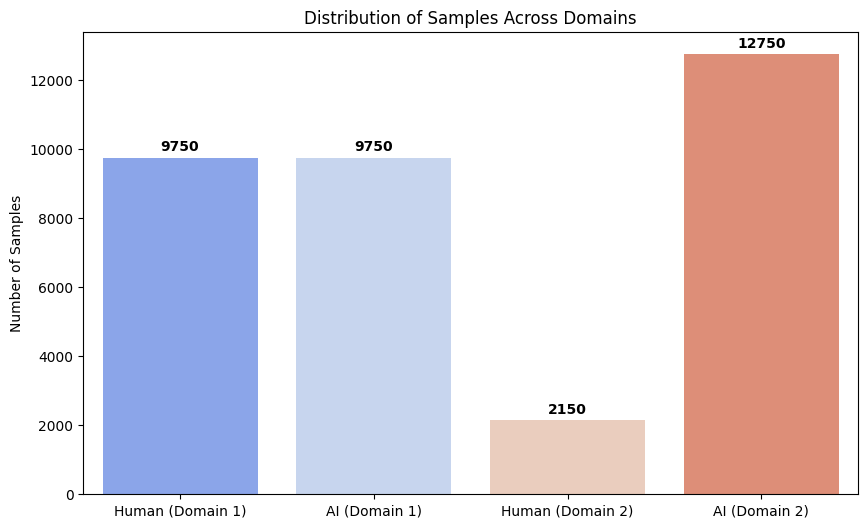

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset details
categories = ['Human (Domain 1)', 'AI (Domain 1)', 'Human (Domain 2)', 'AI (Domain 2)']
values = [9750, 9750, 2150, 12750]

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=categories, y=values, palette="coolwarm")

# Add annotations
for i, v in enumerate(values):
    plt.text(i, v + 100, str(v), ha='center', va='bottom', fontweight='bold')

plt.title('Distribution of Samples Across Domains')
plt.ylabel('Number of Samples')
plt.show()


In [ ]:
# Create bar chart
plt.figure(figsize=(12, 8))
bars1 = plt.bar(labels[0], total_counts[0], color='royalblue', label='Human (Domain 1)')
bars2 = plt.bar(labels[1], total_counts[1], color='coral', label='AI (Domain 1)')
bars3 = plt.bar(labels[2], total_counts[2], color='seagreen', label='Human (Domain 2)')


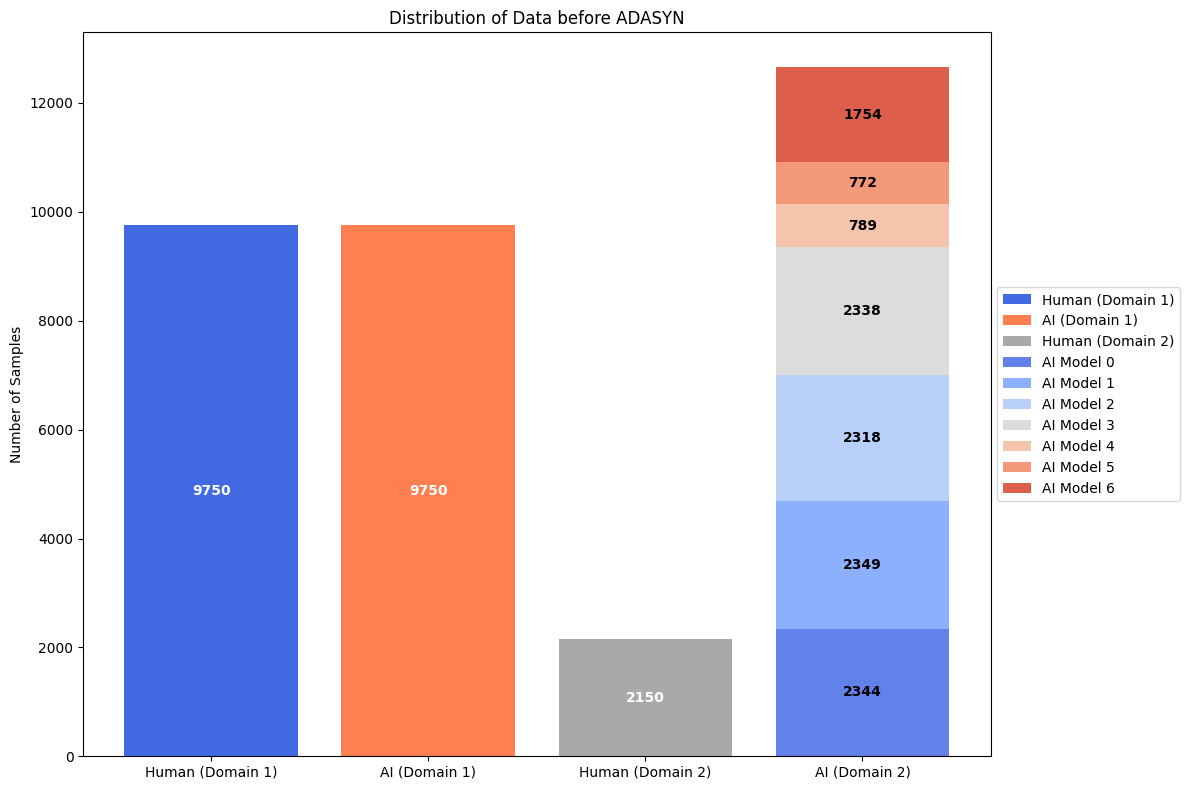

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data
labels = ['Human (Domain 1)', 'AI (Domain 1)', 'Human (Domain 2)', 'AI (Domain 2)']
total_counts = [9750, 9750, 2150, 12750]
ai_model_counts = [2344, 2349, 2318, 2338, 789, 772, 1754]  # For Domain 2 AI
ai_model_labels = [f"AI Model {i}" for i in range(7)]

# Create bar chart
plt.figure(figsize=(12, 8))
bars1 = plt.bar(labels[0], total_counts[0], color='royalblue', label='Human (Domain 1)')
bars2 = plt.bar(labels[1], total_counts[1], color='coral', label='AI (Domain 1)')
bars3 = plt.bar(labels[2], total_counts[2], color='darkgrey', label='Human (Domain 2)')

# Stacked bar for AI models in Domain 2
current_bottom = 0
colors = sns.color_palette("coolwarm", n_colors=len(ai_model_counts))
bars4 = []
for i, count in enumerate(ai_model_counts):
    bar = plt.bar(labels[3], count, bottom=current_bottom, color=colors[i], label=ai_model_labels[i])
    bars4.append(bar)
    current_bottom += count

# Add text annotations
for i, v in enumerate(total_counts[:3]):
    plt.text(i, v / 2, str(v), ha='center', va='center', fontweight='bold', color='white')

# Text annotations for AI (Domain 2) stack bars
cumulative_count = 0
for count in ai_model_counts:
    middle = cumulative_count + count / 2
    plt.text(3, middle, str(count), ha='center', va='center', fontweight='bold', color='black')
    cumulative_count += count

plt.title('Distribution of Data before ADASYN')
plt.ylabel('Number of Samples')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Convert the 'text' column sequences from lists to numpy arrays for easier manipulation
df3['text'] = df3['text'].apply(np.array)

# 3. Shuffling Test: Check mean and variance consistency across random splits
original_mean = df3['text'].apply(np.mean).mean()
original_var = df3['text'].apply(np.var).mean()

shuffled_df = df3.sample(frac=1).reset_index(drop=True)
split1, split2 = np.array_split(shuffled_df, 2)

split1_mean = split1['text'].apply(np.mean).mean()
split1_var = split1['text'].apply(np.var).mean()

split2_mean = split2['text'].apply(np.mean).mean()
split2_var = split2['text'].apply(np.var).mean()

print("Original Mean:", original_mean)
print("Shuffled Split 1 Mean:", split1_mean)
print("Shuffled Split 2 Mean:", split2_mean)
print()
print("Original Variance:", original_var)
print("Shuffled Split 1 Variance:", split1_var)
print("Shuffled Split 2 Variance:", split2_var)


NameError: ignored

The results  obtained suggest that dataset may have properties consistent with the IID (independent and identically distributed) assumption, at least when considering the first moment (mean) and second moment (variance). Here's how we can interpret this:

1. **Mean**:
    - our original data's mean value is \(441.437\).
    - When we randomly shuffled and split our data into two parts, the means of these two parts were \(441.235\) and \(441.639\), respectively.
    - These shuffled mean values are very close to the original mean.

2. **Variance**:
    - The original variance of our data is \(810309.5\).
    - The variances of the two shuffled splits are \(809179.01\) and \(811439.93\), respectively.
    - These shuffled variances are also very close to the original variance.

Given these results, we can make a few observations:

- The mean and variance remain consistent even after shuffling and splitting the data. This suggests that the individual samples (sequences) might not be heavily dependent on their order in the dataset, which is a property we'd expect in IID data.
  
- This does not necessarily mean that the individual numbers within each sequence are independent of each other, but it does suggest that the sequences themselves might be interchangeable without affecting the overall statistical properties of the dataset.


In [ ]:
df3['text_dup'] = df3['text'].apply(tuple)
duplicated_pairs = df3[df3.duplicated(subset='text_dup', keep=False)]
duplicated_pairs.groupby(['label']).count()

,text,domain,model,text_dup
label,,,,
0,921,921,170,921
1,38,38,0,38


In [ ]:
df3['text_dup'] = df3['text'].apply(tuple)
df3.drop_duplicates(subset='text_dup', keep='first', inplace=True)
df3.drop(columns='text_dup', inplace=True)



In [ ]:
df3['text_dup'] = df3['text'].apply(tuple)
duplicated_pairs = df3[df3.duplicated(subset='text_dup', keep=False)]
duplicated_pairs.groupby(['label']).count()

,text,domain,model
label,,,


## MLP baseline
- bow
- no sampling
- no weight
- test acc: 87%

In [ ]:
model = Sequential()

model.add(Dense(50,input_shape=(5000,),activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(100,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(150,activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(200,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()
model.fit(X_train,Y_train,epochs=15,verbose=2)
model.evaluate(X_test,Y_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                250050    
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 100)               5100      
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 150)               15150     
                                                                 
 dropout_2 (Dropout)         (None, 150)               0         
                                                                 
 dense_3 (Dense)             (None, 200)               3

## Optimised MLP
- parameter optimisation
- acc 0.9009302258491516

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Model
optimized_model = Sequential()

optimized_model.add(Dense(128, input_shape=(5000,), activation='relu', kernel_regularizer=l2(0.001)))
optimized_model.add(Dropout(0.3))

optimized_model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
optimized_model.add(Dropout(0.3))

optimized_model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)
optimized_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

optimized_model.summary()
optimized_model.fit(X_train, Y_train, epochs=50, verbose=2, validation_split=0.1, batch_size=32, callbacks=[early_stopping])
optimized_model.evaluate(X_test, Y_test)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               640128    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 656769 (2.51 MB)
Trainable params: 656769 (2.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
726/726

[0.3545358180999756, 0.9009302258491516]

## Optimised MLP - imbalance handling
- model-based
- SMOTE


In [ ]:
df1.loc[df1['label'] == 0, 'model'] = 7 # machine no.7
df1.loc[df1['label'] == 1, 'model'] = 8 # human label as 8

df2['model'] = df2['model'].fillna(9) # human label as 9
df3 = pd.concat([df1, df2], axis=0, ignore_index=True)
df3['model'].describe()
 #0-7: machine; 8-9 human

from sklearn.utils import resample

# Split the dataset based on model values
dfs = [df3[df3['model'] == i] for i in range(10)]  # 0-9 models


In [ ]:
df3.groupby('model').count()

,text,label,domain
model,,,
0.0,2364,2364,2364
1.0,2357,2357,2357
2.0,2339,2339,2339
3.0,2358,2358,2358
4.0,789,789,789
5.0,780,780,780
6.0,1763,1763,1763
7.0,9750,9750,9750
8.0,9750,9750,9750


### model-based

In [ ]:

target_samples = 1488

# Resample machine labels 0-7
for i in range(8):
    if len(dfs[i]) > target_samples:
        # Undersample if the count is greater than 1488
        dfs[i] = resample(dfs[i], replace=False, n_samples=target_samples, random_state=42)
    elif len(dfs[i]) < target_samples:
        # Oversample if the count is less than 1488
        dfs[i] = resample(dfs[i], replace=True, n_samples=target_samples, random_state=42)

# Note: Not resampling human labels 8 and 9, as they are to be kept as they are

# Concatenate results
df_resampled1 = pd.concat(dfs)

# Check the new distribution
print(df_resampled1['model'].value_counts())
#df_resampled

NameError: ignored

In [ ]:
X = sequences_to_bow(df_resampled1['text'], vocab_size)
y = df_resampled1['label'].values

In [ ]:
X_pred = sequences_to_bow(test['text'], 5000)
Xtrain,Ytrain = np.array(X),np.array(y) # model
X_train,X_test,Y_train,Y_test = train_test_split(Xtrain,Ytrain,test_size=0.25,stratify=Ytrain)


In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Model
optimized_model = Sequential()

optimized_model.add(Dense(128, input_shape=(5000,), activation='relu', kernel_regularizer=l2(0.001)))
optimized_model.add(Dropout(0.3))

optimized_model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
optimized_model.add(Dropout(0.3))

optimized_model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)
optimized_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

optimized_model.summary()
optimized_model.fit(X_train, Y_train, epochs=50, verbose=2, validation_split=0.1, batch_size=32, callbacks=[early_stopping])
optimized_model.evaluate(X_test, Y_test)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 128)               640128    
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               16512     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 656769 (2.51 MB)
Trainable params: 656769 (2.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
503/503

[0.3600963056087494, 0.8924550414085388]

In [ ]:
# Model
model = Sequential()

model.add(Dense(50,input_shape=(5000,),activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(100,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(150,activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(200,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

from sklearn.utils import class_weight

class_weights = {0: 1., 1: 2.}
model.fit(X, y, epochs=10, verbose=2, validation_split=0.1, batch_size=32, class_weight=class_weights)



Epoch 1/10
670/670 - 6s - loss: 0.1500 - accuracy: 0.9655 - val_loss: 36.4075 - val_accuracy: 0.1000 - 6s/epoch - 10ms/step
Epoch 2/10
670/670 - 5s - loss: 0.0522 - accuracy: 0.9877 - val_loss: 40.5819 - val_accuracy: 0.1004 - 5s/epoch - 8ms/step
Epoch 3/10
670/670 - 5s - loss: 0.0254 - accuracy: 0.9937 - val_loss: 68.1191 - val_accuracy: 0.0995 - 5s/epoch - 7ms/step
Epoch 4/10
670/670 - 5s - loss: 0.0204 - accuracy: 0.9957 - val_loss: 83.8880 - val_accuracy: 0.0987 - 5s/epoch - 7ms/step
Epoch 5/10
670/670 - 5s - loss: 0.0115 - accuracy: 0.9973 - val_loss: 82.4594 - val_accuracy: 0.0962 - 5s/epoch - 8ms/step
Epoch 6/10
670/670 - 5s - loss: 0.0090 - accuracy: 0.9980 - val_loss: 87.2169 - val_accuracy: 0.1008 - 5s/epoch - 7ms/step
Epoch 7/10
670/670 - 5s - loss: 0.0063 - accuracy: 0.9986 - val_loss: 145.6340 - val_accuracy: 0.0958 - 5s/epoch - 8ms/step
Epoch 8/10
670/670 - 5s - loss: 0.0049 - accuracy: 0.9990 - val_loss: 143.8586 - val_accuracy: 0.0983 - 5s/epoch - 7ms/step
Epoch 9/10
67

In [ ]:
# 3. Predict on the new test data
y_pred = model.predict(X_pred)
y_class_pred = (y_pred > 0.5).astype(int)
list(y_class_pred).count(1)

32/32 [==============================] - 0s 4ms/step


286

### smote
- label-based(0/1): acc 0.91

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import SMOTE
from collections import Counter

vocab_size = 5000

def sequences_to_bow(sequences, vocab_size):
    matrix = np.zeros((len(sequences), vocab_size))
    for i, sequence in enumerate(sequences):
        for token in sequence:
            if token < vocab_size:
                matrix[i][token] += 1
    return matrix

X_vectorized = sequences_to_bow(df3['text'], vocab_size)
y = df3['label'].values

# Display distribution before SMOTE
counter = Counter(y)
print('Before', counter)

# Apply SMOTE for balancing
smote = SMOTE(random_state=42)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X_vectorized, y)

# Display distribution after SMOTE
counter = Counter(y_resampled_smote)
print('After', counter)


Before Counter({0: 22500, 1: 11900})
After Counter({1: 22500, 0: 22500})


In [ ]:
X_pred = sequences_to_bow(test['text'], 5000)
Xtrain,Ytrain = np.array(X_resampled_smote),np.array(y_resampled_smote) # smote
X_train,X_test,Y_train,Y_test = train_test_split(Xtrain,Ytrain,test_size=0.25,stratify=Ytrain)


In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Model
optimized_model = Sequential()

optimized_model.add(Dense(128, input_shape=(5000,), activation='relu', kernel_regularizer=l2(0.001)))
optimized_model.add(Dropout(0.3))

optimized_model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
optimized_model.add(Dropout(0.3))

optimized_model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)
optimized_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

optimized_model.summary()
optimized_model.fit(X_train, Y_train, epochs=50, verbose=2, validation_split=0.1, batch_size=32, callbacks=[early_stopping])
optimized_model.evaluate(X_test, Y_test)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               640128    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 656769 (2.51 MB)
Trainable params: 656769 (2.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
950/950 -

[0.336286723613739, 0.9148444533348083]

In [ ]:

# Model
optimized_model = Sequential()

optimized_model.add(Dense(128, input_shape=(5000,), activation='relu', kernel_regularizer=l2(0.001)))
optimized_model.add(Dropout(0.3))

optimized_model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
optimized_model.add(Dropout(0.3))

optimized_model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)
optimized_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

optimized_model.summary()
optimized_model.fit(Xtrain, Ytrain, epochs=10, verbose=2, validation_split=0.1, batch_size=32,class_weight=class_weights)
#optimized_model.evaluate(X_test, Y_test)


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 128)               640128    
                                                                 
 dropout_30 (Dropout)        (None, 128)               0         
                                                                 
 dense_41 (Dense)            (None, 128)               16512     
                                                                 
 dropout_31 (Dropout)        (None, 128)               0         
                                                                 
 dense_42 (Dense)            (None, 1)                 129       
                                                                 
Total params: 656769 (2.51 MB)
Trainable params: 656769 (2.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# 3. Predict on the new test data
y_pred = optimized_model.predict(X_pred)
y_class_pred = (y_pred > 0.5).astype(int)
list(y_class_pred).count(1)


32/32 [==============================] - 0s 3ms/step


296

### ADASYN

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import ADASYN  # Import ADASYN
from collections import Counter

vocab_size = 5000

def sequences_to_bow(sequences, vocab_size):
    matrix = np.zeros((len(sequences), vocab_size))
    for i, sequence in enumerate(sequences):
        for token in sequence:
            if token < vocab_size:
                matrix[i][token] += 1
    return matrix

X_vectorized = sequences_to_bow(df3['text'], vocab_size)
y = df3['label'].values

# Display distribution before ADASYN
counter = Counter(y)
print('Before', counter)

# Apply ADASYN for balancing
adasyn = ADASYN(random_state=42)  # Create an ADASYN instance
X_resampled_adasyn, y_resampled_adasyn = adasyn.fit_resample(X_vectorized, y)  # Use ADASYN for resampling

# Display distribution after ADASYN
counter = Counter(y_resampled_adasyn)
print('After', counter)



Before Counter({0: 21818, 1: 11879})
After Counter({0: 21818, 1: 20329})


In [ ]:
# same idea, but want to keep the model label for plotting

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import ADASYN  # Import ADASYN
from collections import Counter

# Step 1: Stack text, domain, and model data side by side
X_combined = np.column_stack((
    sequences_to_bow(df3['text'], vocab_size),
    df3['domain'].fillna(0).values,  # fill NaNs with 0 for ADASYN
    df3['model'].fillna(7).values   # fill NaNs with 7 for ADASYN
))

# Before applying ADASYN, it's advisable to standardize the domain and model columns
scaler = StandardScaler()
X_combined[:, -2:] = scaler.fit_transform(X_combined[:, -2:])

# Step 2: Apply ADASYN to resample this combined data
adasyn = ADASYN(random_state=42)
X_resampled_combined, y_resampled_adasyn = adasyn.fit_resample(X_combined, y)

# Step 3: Split the resampled data back into text, domain, and model
X_resampled_adasyn = X_resampled_combined[:, :-2]  # Only the text data
domain_resampled = scaler.inverse_transform(X_resampled_combined[:, -2:])[:, 0]
model_resampled = scaler.inverse_transform(X_resampled_combined[:, -2:])[:, 1]

# Check distribution
print('Before', Counter(y))
print('After', Counter(y_resampled_adasyn))

print(domain_resampled)
print(model_resampled)


Before Counter({0: 21818, 1: 11879})
After Counter({0: 21818, 1: 20362})
[1. 1. 1. ... 2. 2. 2.]
[7. 7. 7. ... 7. 7. 7.]


In [ ]:
df3.groupby('model').count()

,text,label,domain,text_strings
model,,,,
0.0,2344,2344,2344,2344
1.0,2349,2349,2349,2349
2.0,2318,2318,2318,2318
3.0,2338,2338,2338,2338
4.0,789,789,789,789
5.0,772,772,772,772
6.0,1754,1754,1754,1754


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a DataFrame from resampled data
df_resampled = pd.DataFrame({'domain': domain_resampled, 'model': model_resampled, 'label':y_resampled_adasyn})


In [ ]:
df_resampled.groupby('label').count()

,domain,model
label,,
0,21818,21818
1,20362,20362


In [ ]:
df_resampled.groupby(['label','model']).count()

domain
label model        
0     0.0      2344
      1.0      2349
      2.0      2318
      3.0      2338
      4.0       789
      5.0       772
      6.0      1754
      7.0      9154
1     7.0     20362

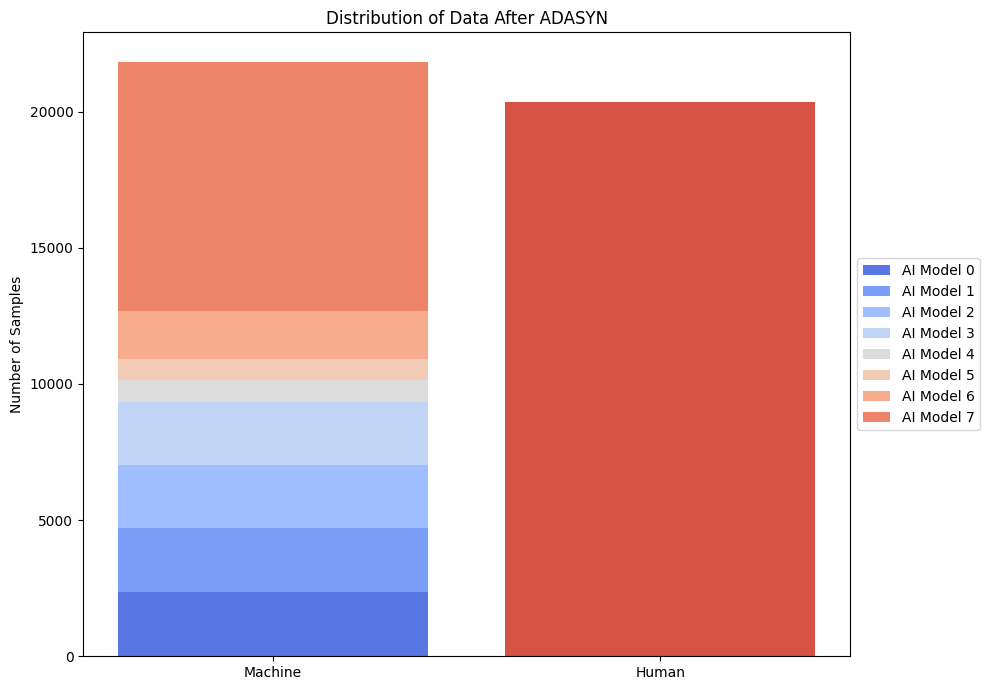

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data
labels = ['Machine', 'Human']
machine_counts = [2344, 2349, 2318, 2338, 789, 772, 1754, 9154]
machine_labels = [f"AI Model {i}" for i in range(8)] + ['Human']
total_human = 20362

# Create bar chart
plt.figure(figsize=(10, 7))

# Stacked bar for Machine label
current_bottom = 0
colors = sns.color_palette("coolwarm", n_colors=len(machine_counts)+1)
for i, count in enumerate(machine_counts):
    plt.bar(labels[0], count, bottom=current_bottom, color=colors[i], label=machine_labels[i])
    current_bottom += count

# Single bar for Human label
plt.bar(labels[1], total_human, color=colors[8])

plt.title('Distribution of Data After ADASYN')
plt.ylabel('Number of Samples')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(X_resampled_adasyn,y_resampled_adasyn,test_size=0.25,stratify=y_resampled_adasyn)


In [ ]:

# Model
optimized_model = Sequential()

optimized_model.add(Dense(128, input_shape=(5000,), activation='relu', kernel_regularizer=l2(0.001)))
optimized_model.add(Dropout(0.3))

optimized_model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
optimized_model.add(Dropout(0.3))

optimized_model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)
optimized_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

optimized_model.summary()
class_weights = {0: 1., 1: 2.}
optimized_model.fit(X_train, Y_train, epochs=10, verbose=2, validation_split=0.1, batch_size=32,class_weight=class_weights)
#optimized_model.evaluate(X_test, Y_test)
optimized_model.evaluate(X_test, Y_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               640128    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 656769 (2.51 MB)
Trainable params: 656769 (2.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
890/890 -

[0.4778022766113281, 0.8899117112159729]

#### evaluations

330/330 [==============================] - 1s 2ms/step


<Axes: >

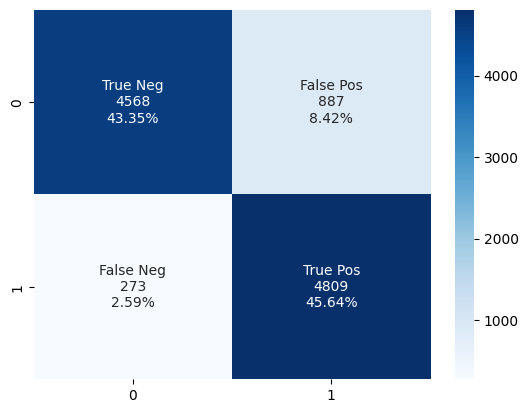

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = optimized_model.predict(X_test)
y_class_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(Y_test,y_class_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

330/330 [==============================] - 1s 2ms/step


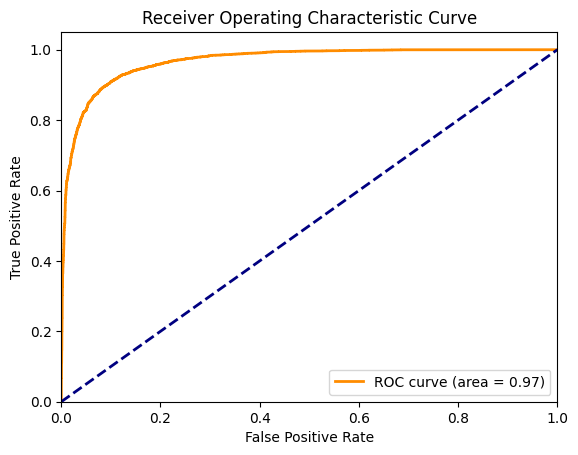

In [ ]:
y_probs = optimized_model.predict(X_test)  # These are probabilities that the class is 1
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Y_test, y_probs)
roc_auc = auc(fpr, tpr)
import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()


# Final Prediction

In [ ]:
# 3. Predict on the new test data
# Model
optimized_model = Sequential()

optimized_model.add(Dense(128, input_shape=(5000,), activation='relu', kernel_regularizer=l2(0.001)))
optimized_model.add(Dropout(0.3))

optimized_model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
optimized_model.add(Dropout(0.3))

optimized_model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)
optimized_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

optimized_model.summary()
class_weights = {0: 1., 1: 2.}
optimized_model.fit(X_train, Y_train, epochs=10, verbose=2, validation_split=0.1, batch_size=32,class_weight=class_weights)
#optimized_model.evaluate(X_test, Y_test)
optimized_model.evaluate(X_resampled_adasyn, y_resampled_adasyn) # use whole data set to train, no train test split

y_pred = optimized_model.predict(X_pred)
y_class_pred = (y_pred > 0.367).astype(int)
list(y_class_pred).count(1)

32/32 [==============================] - 0s 2ms/step


499

In [ ]:
test['class'] = y_class_pred
test[['id', 'class']].to_csv('smote_mlp5.csv', index= False) #83.2% on kaggle

In [ ]:
test[['id', 'class']].to_csv('smote_mlp5.csv', index= False) #83.2% on kaggle

In [ ]:
test[['id', 'class']].to_csv('smote_mlp6.csv', index= False) #85% on kaggle

# Further Exploration

## data augmentation
suggested to be used before imbalance handling (if we are using ADASYN)

In [ ]:
import random

def random_insertion(sequence, n):
    for _ in range(n):
        add_random_token(sequence)
    return sequence

def random_deletion(sequence, p):
    if len(sequence) == 1:
        return sequence
    remaining = list(filter(lambda x: random.uniform(0,1) > p, sequence))
    if len(remaining) == 0:
        return [random.choice(sequence)]
    return remaining

def random_swap(sequence, n):
    length = len(sequence)
    for _ in range(n):
        idx1, idx2 = random.randint(0, length-1), random.randint(0, length-1)
        sequence[idx1], sequence[idx2] = sequence[idx2], sequence[idx1]
    return sequence

def add_random_token(sequence):
    if len(sequence) == 0 or max(sequence) == 0:
        # Either add a default token or skip this sequence.
        sequence.append(1)
        return
    position = random.randint(0, len(sequence)-1)
    random_token = random.randint(1, max(sequence))
    sequence.insert(position, random_token)


In [ ]:
from sklearn.utils import shuffle
from imblearn.over_sampling import ADASYN
from collections import Counter
batch_size = 5000
# Shuffle data
df3 = shuffle(df3)

num_batches = int(len(df3) / batch_size) + (1 if len(df3) % batch_size != 0 else 0)

for batch in range(num_batches):
    start_idx = batch * batch_size
    end_idx = min((batch + 1) * batch_size, len(df3))

    batch_data = df3.iloc[start_idx:end_idx]

    augmented_data = []
    augmented_labels = []

    for text, label in zip(batch_data['text'].values, batch_data['label'].values):
        # Original data
        augmented_data.append(text)
        augmented_labels.append(label)

        # Augment data
        augmented_sequence = random_insertion(list(text), 1)
        augmented_sequence = random_deletion(augmented_sequence, 0.1)
        augmented_sequence = random_swap(augmented_sequence, 2)

        augmented_data.append(augmented_sequence)
        augmented_labels.append(label)

    augmented_data = np.array(augmented_data, dtype=object)
    augmented_labels = np.array(augmented_labels)

    # Convert augmented data to bag-of-words representation
    X_vectorized = sequences_to_bow(augmented_data, vocab_size)
    y = np.array(augmented_labels)

    # Display distribution before ADASYN
    counter = Counter(y)
    print(f'Batch {batch + 1} - Before', counter)

    # Apply ADASYN for balancing
    adasyn = ADASYN(random_state=42)
    X_resampled_adasyn, y_resampled_adasyn = adasyn.fit_resample(X_vectorized, y)

    # Display distribution after ADASYN
    counter = Counter(y_resampled_adasyn)
    print(f'Batch {batch + 1} - After', counter)


Batch 1 - Before Counter({0: 6450, 1: 3550})
Batch 1 - After Counter({1: 6824, 0: 6450})
Batch 2 - Before Counter({0: 6464, 1: 3536})
Batch 2 - After Counter({1: 6493, 0: 6464})
Batch 3 - Before Counter({0: 6628, 1: 3372})
Batch 3 - After Counter({1: 6780, 0: 6628})
Batch 4 - Before Counter({0: 6574, 1: 3426})
Batch 4 - After Counter({1: 6670, 0: 6574})
Batch 5 - Before Counter({0: 6520, 1: 3480})
Batch 5 - After Counter({1: 6686, 0: 6520})
Batch 6 - Before Counter({0: 6616, 1: 3384})
Batch 6 - After Counter({1: 6858, 0: 6616})
Batch 7 - Before Counter({0: 5748, 1: 3052})
Batch 7 - After Counter({1: 6138, 0: 5748})


In [ ]:
from sklearn.utils import shuffle
from imblearn.over_sampling import ADASYN
from collections import Counter
batch_size = 5000

# Shuffle data
df3 = shuffle(df3)

num_batches = int(len(df3) / batch_size) + (1 if len(df3) % batch_size != 0 else 0)

all_X_resampled = []
all_y_resampled = []

for batch in range(num_batches):
    start_idx = batch * batch_size
    end_idx = min((batch + 1) * batch_size, len(df3))

    batch_data = df3.iloc[start_idx:end_idx]

    augmented_data = []
    augmented_labels = []

    for text, label in zip(batch_data['text'].values, batch_data['label'].values):
        # Original data
        augmented_data.append(text)
        augmented_labels.append(label)

        # Augment data
        augmented_sequence = random_insertion(list(text), 1)
        augmented_sequence = random_deletion(augmented_sequence, 0.1)
        augmented_sequence = random_swap(augmented_sequence, 2)

        augmented_data.append(augmented_sequence)
        augmented_labels.append(label)

    augmented_data = np.array(augmented_data, dtype=object)
    augmented_labels = np.array(augmented_labels)

    # Convert augmented data to bag-of-words representation
    X_vectorized = sequences_to_bow(augmented_data, vocab_size)
    y = np.array(augmented_labels)

    # Apply ADASYN for balancing
    adasyn = ADASYN(random_state=42)
    X_resampled_adasyn, y_resampled_adasyn = adasyn.fit_resample(X_vectorized, y)

    all_X_resampled.append(X_resampled_adasyn)
    all_y_resampled.append(y_resampled_adasyn)

# Combine data from all batches
all_X_resampled = np.vstack(all_X_resampled)
all_y_resampled = np.hstack(all_y_resampled)

# Display distribution of combined data
counter = Counter(all_y_resampled)
print('Overall After Resampling', counter)


Overall After Resampling Counter({1: 45690, 0: 45000})


In [ ]:
list(all_y_resampled).count(1)

44613

In [ ]:
np.save('all_X_resampled.npy', all_X_resampled)
np.save('all_y_resampled.npy', all_y_resampled)


In [ ]:
all_X_resampled = np.load('all_X_resampled.npy')
all_y_resampled = np.load('all_y_resampled.npy')



In [ ]:
# Model
optimized_model = Sequential()

optimized_model.add(Dense(128, input_shape=(5000,), activation='relu', kernel_regularizer=l2(0.001)))
optimized_model.add(Dropout(0.3))

optimized_model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
optimized_model.add(Dropout(0.3))

optimized_model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)
optimized_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

optimized_model.summary()
class_weights = {0: 1., 1: 2.}
optimized_model.fit(all_X_resampled, all_y_resampled, epochs=10, verbose=2, validation_split=0.1, batch_size=32,class_weight=class_weights)
#optimized_model.evaluate(X_test, Y_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               640128    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 656769 (2.51 MB)
Trainable params: 656769 (2.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
2551/2551

In [ ]:
X_pred = sequences_to_bow(test['text'], 5000)

y_pred = optimized_model.predict(X_pred)


32/32 [==============================] - 0s 4ms/step


In [ ]:

y_class_pred = (y_pred > 0.3).astype(int)
list(y_class_pred).count(1)

450

In [ ]:
test['class'] = y_class_pred
test[['id', 'class']].to_csv('smote_mlp8.csv', index= False) #

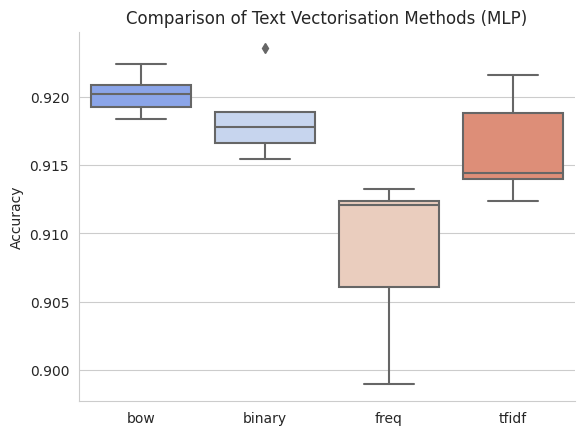

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data
data = {
    'bow': [0.919265, 0.920882, 0.918341, 0.920189, 0.922384],
    'binary': [0.915454, 0.923539, 0.917764, 0.918919, 0.916609],
    'freq': [0.898937, 0.906098, 0.913259, 0.912104, 0.912335],
    'tfidf': [0.921575, 0.918803, 0.912335, 0.913952, 0.914414]
}

df = pd.DataFrame(data)
palette = ["#3498db", "#e74c3c", "#2ecc71", "#f39c12"]

# Boxplot
# Seaborn boxplot
sns.set_style("whitegrid")  # Set Seaborn style


sns.boxplot(data=df,palette="coolwarm")
plt.title('Comparison of Text Vectorisation Methods (MLP)')
plt.ylabel("Accuracy")
sns.despine()  # Remove top and right axes
sns.set_context("talk")  # Set context to "talk" for larger labels
sns.set(rc={'figure.figsize':(10,6)})  # Set figure size
sns.set(font_scale=1.2)  # Adjust font size




## n-gram optimsation (based on ADASYN)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import ADASYN
from collections import Counter

vocab_size = 5000

# Initialize a CountVectorizer to consider only 3-grams
vectorizer = CountVectorizer(ngram_range=(3, 3), max_features=vocab_size)

# Fit the CountVectorizer on the texts and transform the texts into BoW representation
X_vectorized = vectorizer.fit_transform(df3['text_strings']).toarray()
y = df3['label'].values

# Display distribution before ADASYN
counter = Counter(y)
print('Before', counter)

# Apply ADASYN for balancing
adasyn = ADASYN(random_state=42)  # Create an ADASYN instance
X_resampled_adasyn, y_resampled_adasyn = adasyn.fit_resample(X_vectorized, y)  # Use ADASYN for resampling

# Display distribution after ADASYN
counter = Counter(y_resampled_adasyn)
print('After', counter)
np.save('X_resampled_adasyn.npy', X_resampled_adasyn)
np.save('y_resampled_adasyn.npy', y_resampled_adasyn)


Before Counter({0: 21818, 1: 11879})
After Counter({0: 21818, 1: 21670})


In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(X_resampled_adasyn,y_resampled_adasyn,test_size=0.25,stratify=y_resampled_adasyn)

# Model
optimized_model = Sequential()

optimized_model.add(Dense(128, input_shape=(5000,), activation='relu', kernel_regularizer=l2(0.001)))
optimized_model.add(Dropout(0.3))

optimized_model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
optimized_model.add(Dropout(0.3))

optimized_model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)
optimized_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

optimized_model.summary()
class_weights = {0: 1., 1: 2.}
optimized_model.fit(X_train, Y_train, epochs=10, verbose=2, validation_split=0.1, batch_size=32,class_weight=class_weights)
#optimized_model.evaluate(X_test, Y_test)
optimized_model.evaluate(X_test, Y_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               640128    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 656769 (2.51 MB)
Trainable params: 656769 (2.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
918/918 -